# Sequence to Sequence Preprocessing in Pytorch

**|| Jonty Sinai ||** 28-04-2019

In this notebook I show how a **translation dataset** can be preprocessed into pairs of input and target sequences for training a sequence-to-sequence model with PyTorch. This dataset will then be used to test the implementation of two of the original sequence-to-sequence architectures introduced in [Sequence to Sequence Learning with Neural Networks](https://arxiv.org/abs/1409.3215) (Ilya Sutskever et al 2014) and [Learning Phrase Representations using RNN Encoder-Decoder for Statistical Machine Translation](https://arxiv.org/abs/1406.1078)(Kyunghyun Cho et al 2014) respectively. 

The dataset which I will use is a simplified English-French translation dataset based on the [official PyTorch sequence-to-sequence tutorial](https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html#sphx-glr-intermediate-seq2seq-translation-tutorial-py). Whereas in my [ResNet implementation](https://github.com/JontySinai/artificial_neural_networks/blob/master/notebooks/resnet.ipynb) the goal was to explore modular composeability with PyTorch, the goal here is to explore sequence-to-sequence design patterns and engineering with PyTorch.

> **Note:** Compared to computer vision, feature selection and data preprocessing in natural language processing (NLP) requires more care and attention. There is no correct way of preprocessing text, although there are many incorrect ways. Choices must be made carefully and efficiently. As a result, a good portion of this notebook is spent preprocessing the dataset and converting it into the right format for sequence-to-sequence learning.

In [17]:
%matplotlib inline

import os
import re
import random
import unicodedata
from io import open
from collections import defaultdict, Counter

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler

import numpy as np
import matplotlib.pyplot as plt

HOME = os.environ['AI_HOME']
ROOT = os.path.join(HOME, 'artificial_neural_networks')
DATA = os.path.join(ROOT, 'data')
ENG_FR = os.path.join(DATA, 'english_french')

random.seed(1901)
np.random.seed(1901)
torch.manual_seed(1901)

## Data Preprocessing

English-French sentence pairs can be downloaded from the PyTorch translation tutorial [here](https://download.pytorch.org/tutorial/data.zip) (the original data comes from [https://tatoeba.org/eng/downloads](https://tatoeba.org/eng/downloads) and has been paired thanks to [https://www.manythings.org/anki/](https://www.manythings.org/anki/)). 

We will need to do the hardwork of preprocessing this data into tensors which we can feed into our model. We'll start by exploring the dataset and then understanding the I/O requirements of the model architecture. This will inform our choices for preprocessing. Since this is a sequence-to-sequence model, we'll need to be careful to ensure that pairs of input-output sequences are aligned during training and evaluation.

### Data Preview

The data is stored on one file with each line representing an English-French sentence pair. Each English and French sentence is tab separated.

In [2]:
data_path = os.path.join(ENG_FR, 'eng-fra.txt')

In [3]:
raw_pairs = open(data_path, encoding='utf-8').read().strip().split('\n')

for line in raw_pairs[:10]:
    print(line)

Go.	Va !
Run!	Cours !
Run!	Courez !
Wow!	Ça alors !
Fire!	Au feu !
Help!	À l'aide !
Jump.	Saute.
Stop!	Ça suffit !
Stop!	Stop !
Stop!	Arrête-toi !


### Unicode Normalisation

As you can see there are some Unicode characters such as "À" and "Ç". Raw Unicode can be problematic for deep learning as seemingly identical characters on screen can have different representations on disk. For this reason we will need to _normalise_ Unicode characters so that representation is consistent. For more detail on why Unicode normalisation is important see this blogpost: [When "Zoë" !== "Zoë". Or why you need to normalize Unicode strings](https://withblue.ink/2019/03/11/why-you-need-to-normalize-unicode-strings.html) by [Alessandro Segala](https://withblue.ink/about.html). 

Unicode characters can be normalised by converting them into a so-called "canonical form" of which there are four. We will used **NFD** or [Unicode Normal Form Decomposition](https://unicode.org/reports/tr15/#Norm_Forms) to decompose characters with accents. For example "À" will be decomposed into "A" and "̖". We will then have to remove the accent using a filter on so-called _non-spacing mark_ characters. The solution is taken from the PyTorch tutorial (originally StackOverflow) below:

In [4]:
def unicode_normalisation(s):
    # ref: https://stackoverflow.com/a/518232/2809427
    return ''.join(
        char for char in unicodedata.normalize('NFD', s)  # "À" -->  "A" + "̖"
        if unicodedata.category(char) != 'Mn')  # remove "̖"s

In [5]:
for line in raw_pairs[:10]:
    print(unicode_normalisation(line))

Go.	Va !
Run!	Cours !
Run!	Courez !
Wow!	Ca alors !
Fire!	Au feu !
Help!	A l'aide !
Jump.	Saute.
Stop!	Ca suffit !
Stop!	Stop !
Stop!	Arrete-toi !


We will then remove all non-letter characters such as numbers and punctuation, keeping only the end of sentence markers ".", "!", "?", which we will add a space in front of so we can treat them as separate tokens. As part of standard string normalisation for NLP we will convert all characters to lowercase and strip whitespace. 

>**Note:** as a result words like "aren't" will become "aren" "t" and will be treated as separate tokens.

In [6]:
def normalise_string(s):
    s = unicode_normalisation(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)  # add space in front of ".", "!" "?"
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)  # remove unwanted characets
    return s

In [7]:
for line in raw_pairs[:10]:
    print(normalise_string(line))

go . va !
run ! cours !
run ! courez !
wow ! ca alors !
fire ! au feu !
help ! a l aide !
jump . saute .
stop ! ca suffit !
stop ! stop !
stop ! arrete toi !


### Tokenisation

The next step is to tokenise each sentence. Tokenisation is useful because it reduces sentences (which occur uniquely in the dataset) into smaller units. We can then represent the _feature space_ of each language in terms of these tokens. This feature space is orders of magnitude smaller than the sentence space (cardinality ~ dataset) and allows us to represent sentences in terms of shared features. Finally we can treat each _timestep_ in each sentence as a token. 

> Thus we can represent each sentence as a **sequence of tokens**.

One important aspect of tokenisation is that we can _index each unique token_ for each language to form what is known as **vocabulary**, which is _1-to-1_ mapping between indices and tokens.

An example of a vocabulary mapping, containing two special tokens `<SOS>` and `<EOS>` start/end of sequence markers, is as follows:

<img src="assets/word-encoding.png">

In [8]:
def tokenise(sentence):
    return sentence.split(' ')

def tokenise_pair(pair):
    return [tokenise(normalise_string(s)) for s in pair.split('\t')]

In [9]:
for line in raw_pairs[:5]:
    print(tokenise_pair(line)[0], '\t', tokenise_pair(line)[1])

['go', '.'] 	 ['va', '!']
['run', '!'] 	 ['cours', '!']
['run', '!'] 	 ['courez', '!']
['wow', '!'] 	 ['ca', 'alors', '!']
['fire', '!'] 	 ['au', 'feu', '!']


Each sentence in each pair is now a sequence of tokens.

#### Remove Low Frequency Tokens

Those familiar with standard NLP preprocessing will know that the tokenisation process is typically followed by the removal of stopwords (such as "the", "a"), pronouns (such as "they") and lemmatisation ("going" --> "go"). For neural machine translation we do want to keep stopwords, pronouns and tense as these are important for accurate translation. 

One of the reasons why such filtering of tokens is important is to reduce the size of the vocabulary - as we will see below, this will reduce complexity when computing vector representations. However if stopwords and lemmatisation is important for translation, then how can we reduce the size of the vocabulary? One way is to remove tokens with relatively low frequency. For example, if some of our training pairs contained references to specific names or terms, then those tokens will be noise in the translation task. While it is hard to identify all such words, it is safe to assume that they occur with low frequency.

In fact, term frequencies tend to be long tailed, so we can significantly reduce the vocabulary dimension by removing all tokens with very low frequency.

To see this, let's go through all the English tokens and plots its distribution by frequency.

In [14]:
en_tokens = []
for line in raw_pairs:
    en_tokens.extend(tokenise_pair(line)[0])
    
print(len(en_tokens))

1022097


As you can see there are 1 022 097 English tokens in total. We can count the unique number of tokens and their frequencies using Python's `Counter` container

In [44]:
en_term_frequencies = Counter(en_tokens)

print(len(en_term_frequencies))

13041


In total there are 13 041 tokens. Let's see what the the distribution of their frequencies are:

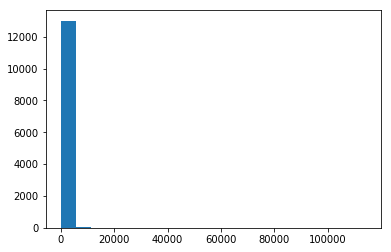

In [21]:
plt.hist([freq for _, freq in en_term_frequencies.items()], bins=20)
plt.show()

As you can see, most of the tokens have a similar frequency with a few of them having very high frequency (for example, stop words). We can inspect the mid to low frequency distribution by clipping the high frequency tokens:

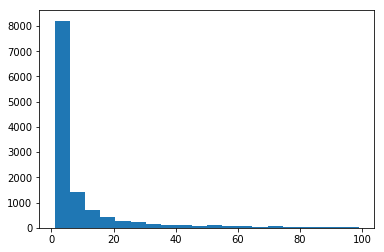

In [32]:
plt.hist([freq for _, freq in en_term_frequencies.items() if freq < 100], bins=20)
plt.show()

Here we can see that there is a very high number of tokens with very low frequency. These are the ones which we will wish to prune. We can prune tokens by removing the highest (lowest) tail of the terms sorted by frequency in descending (ascending) order.

In [35]:
descending_order_percentile = 99
ascending_order_percentile = 100 - descending_order_percentile

# np.percentile sorts in ascending order by default
freq_threshold = np.percentile([freq for _, freq in en_term_frequencies.items()], ascending_order_percentile)

print(freq_threshold)

1.0


We can now remove all tokens with frequency less or equal to 1 and reduce dimensionality of the vocabulary by a factor in the order of 2.

In [39]:
keep_tokens = []
for term, freq in en_term_frequencies.items():
    if freq > freq_threshold:
        keep_tokens.append(term)
        
print(len(keep_tokens))

8910


>**Note:** In the vocabulary class which we'll create below we'll use `defaultdict` to count term frequencies one at a time rather than `Counter`. This is because we will create the vocabulary as we encounter terms

#### Onehot-Vectors

Typicall we convert each token into a onehot-vector of dimensionality $\mathbb{R}^{\lvert V \rvert}$ where $\lvert V \rvert$ is the vocabulary size and each direction is a unique token.

In the following example, taken from Andrew Ng's Deep Learning Course, an example English vocabulary could contain 10 000 unique tokens, including a special `"<UNK>"` token to represent unknown tokens. If **"queen"** has index **7157** then it will have a $1$ at the 7157<sup>th</sup> direction in $\mathbb{R}^{\lvert V \rvert}$ and $0$ everywhere else.

<img src="assets/onehot-vectors.png" width="600">
<br/>

#### Continuous Vector Embeddings

The problem with onehot vector representations is that they encode information inefficiently. In a vector of length 10,000, 9,999 directions contain zero information content and 1 direction contains 100% of the information content! A well studied way of encoding information more efficiently is to _compress_ the _sparse_ onehot vector into a _dense_ or _continuous_ vector representation with smaller dimensionality. We lose the meaning of each direction corresponding to a unique vector but we gain a memory cost saving. 

> Even more than that, there is a whole line of research studying continuous vector embeddings where the goal is to learn meaningful directions in an unsupervised way. The most famous of which are [word2vec](https://arxiv.org/abs/1301.3781), [fastText](https://arxiv.org/abs/1607.01759) and [GloVe](https://nlp.stanford.edu/projects/glove/). The encoding efficiency of these embeddings have been shown to improve downstream tasks such as sequence-to-sequence modelling. 

Using such pre-trained embeddings, words such as **"queen"** can now be decomposed into a smaller, continuous vector where certain directions \*may have certain encoded meanings. 

<img src="assets/embedding-vectors.png" width="600">
<br/>

### Sequence Encoding

Since we will typically pass onehot vectors through an initial **embedding layer (transformation)**, we do not need to represent each token as a onehot vector in PyTorch. This is because under the hood, PyTorch will precompute the embeddings for each unique token and use a lookup-table to map each token to its embedding vector. Thus we can instead just use the token index at each timestep so that the word **"queen"** occuring at time $t$ will simply be represented by **7157** at time $t$.

>Thus by indexing tokens uniquely for each language we can represent each sentence as a **sequence of indices**.

We will manage tokenisation, indexing and sequence conversion using a **Vocabulary** class. This class will be responsible for:

- Mapping tokens to indices and vice-versa.
    - This will include the three special tokens mentioned earlier, namely `<SOS>`, `<EOS>` and `<UNK>`.
- Adding tokens to the vocabulary.
- Keeping track of vocabulary size.

We will then use this class to convert **sequences of tokens** into **sequences of indices**. 

In [96]:
PAD_TOKEN = 0
SOS_TOKEN = 1
EOS_TOKEN = 2
UNK_TOKEN = 3

class Vocab:
    
    def __init__(self, name: str, tokens: list, prune_at: int):
        self.name = name
        self.index2token = ["<pad>", "<sos>", "<eos>", "<unk>"]
        self.token2index = defaultdict(lambda: UNK_TOKEN,  # return UNK_TOKEN if unknown token encountered
                                       {"<pad>": PAD_TOKEN, "<sos>": SOS_TOKEN, "<eos>": EOS_TOKEN})  # init key-vals
        
        self.num_pruned = 0
        
        self._add_tokens(tokens, prune_at)
        
    def _add_tokens(self, tokens: list, descending_percentile: int):
        """
            tokens (list): list of non-unique tokens
        """
        
        self.term_frequencies = Counter(tokens)
        
        # np.percentile sorts an array in ascending order so if we wish to prune 
        # tokens with term frequencies in the lowest 99th percentile, we can calculate 
        # the threshold at the 1st percentile in ascending order.
        ascending_percentile = 100 - descending_percentile
        freq_threshold = np.percentile(
            [[freq for freq in self.term_frequencies.values()]], ascending_percentile)
        
        for term, freq in self.term_frequencies.items():
            if freq >= freq_threshold:
                self.index2token.append(term)
            else:
                self.num_pruned += 1
                
        # now update token2index:
        for token in self.index2token[4:]:
            self.token2index[token] = self.index2token.index(token)
            
    def __len__(self):
        return len(self.index2token)
    
    def __str__(self):
        return str(self.token2index)
    

### Test: Vocab

Let's now test the vocabulary class on the first 10 pairs, showing how it will be used to create sequences of indices from sequences of tokens.

In [81]:
en_token_sequences = []
en_tokens = []
fr_token_sequences = []
fr_tokens = []
for line in raw_pairs[:10]:
    pair = tokenise_pair(line)
    en_token_sequences.append(pair[0])
    en_tokens.extend(pair[0])
    fr_token_sequences.append(pair[1])
    fr_tokens.extend(pair[1])
    
print(en_tokens)
print('\n', fr_tokens)

['go', '.', 'run', '!', 'run', '!', 'wow', '!', 'fire', '!', 'help', '!', 'jump', '.', 'stop', '!', 'stop', '!', 'stop', '!']

 ['va', '!', 'cours', '!', 'courez', '!', 'ca', 'alors', '!', 'au', 'feu', '!', 'a', 'l', 'aide', '!', 'saute', '.', 'ca', 'suffit', '!', 'stop', '!', 'arrete', 'toi', '!']


In [82]:
en_vocab = Vocab("en", en_tokens, prune_at=100)
print(en_vocab)

defaultdict(<function Vocab.__init__.<locals>.<lambda> at 0x7f8143692d08>, {'<pad>': 0, '<sos>': 1, '<eos>': 2, '.': 4, 'run': 5, '!': 6, 'stop': 7})


In [55]:
en_index_sequences = []
for sentence in en_token_sequences[:10]:
    sequence = [en_vocab.token2index[t] for t in sentence]
    en_index_sequences.append(sequence)

print(en_index_sequences)

[[4, 5], [6, 7], [6, 7], [8, 7], [9, 7], [10, 7], [11, 5], [12, 7], [12, 7], [12, 7]]


In [56]:
for token_seq, idx_seq in zip(en_token_sequences, en_index_sequences):
    print(token_seq, ' : ', idx_seq)

['go', '.']  :  [4, 5]
['run', '!']  :  [6, 7]
['run', '!']  :  [6, 7]
['wow', '!']  :  [8, 7]
['fire', '!']  :  [9, 7]
['help', '!']  :  [10, 7]
['jump', '.']  :  [11, 5]
['stop', '!']  :  [12, 7]
['stop', '!']  :  [12, 7]
['stop', '!']  :  [12, 7]


And we can do the same for French

In [57]:
fr_vocab = Vocab("fr", fr_tokens, prune_at=100)

fr_index_sequences = []
for sentence in fr_token_sequences[:10]:
    sequence = [fr_vocab.token2index[t] for t in sentence]
    fr_index_sequences.append(sequence)
    
for token_seq, idx_seq in zip(fr_token_sequences, fr_index_sequences):
    print(token_seq, ' : ', idx_seq)

['va', '!']  :  [4, 5]
['cours', '!']  :  [6, 5]
['courez', '!']  :  [7, 5]
['ca', 'alors', '!']  :  [8, 9, 5]
['au', 'feu', '!']  :  [10, 11, 5]
['a', 'l', 'aide', '!']  :  [12, 13, 14, 5]
['saute', '.']  :  [15, 16]
['ca', 'suffit', '!']  :  [8, 17, 5]
['stop', '!']  :  [18, 5]
['arrete', 'toi', '!']  :  [19, 20, 5]


In [58]:
print(fr_vocab)

defaultdict(<function Vocab.__init__.<locals>.<lambda> at 0x7f813fe7de18>, {'<pad>': 0, '<sos>': 1, '<eos>': 2, 'va': 4, '!': 5, 'cours': 6, 'courez': 7, 'ca': 8, 'alors': 9, 'au': 10, 'feu': 11, 'a': 12, 'l': 13, 'aide': 14, 'saute': 15, '.': 16, 'suffit': 17, 'stop': 18, 'arrete': 19, 'toi': 20})


### Tensor Sequences in PyTorch

The next step is to convert the sequence of indices into tensors for training and prediction using PyTorch. At it's most basic we can convert an array to a tensor as follows:

In [60]:
en_tensor_samples = []
for idx_seq in en_index_sequences:
    tensor_seq = torch.tensor(idx_seq)
    en_tensor_samples.append(tensor_seq)
    print(idx_seq, ' : ', tensor_seq)

[4, 5]  :  tensor([4, 5])
[6, 7]  :  tensor([6, 7])
[6, 7]  :  tensor([6, 7])
[8, 7]  :  tensor([8, 7])
[9, 7]  :  tensor([9, 7])
[10, 7]  :  tensor([10,  7])
[11, 5]  :  tensor([11,  5])
[12, 7]  :  tensor([12,  7])
[12, 7]  :  tensor([12,  7])
[12, 7]  :  tensor([12,  7])


In [61]:
fr_tensor_samples = []
for idx_seq in fr_index_sequences:
    tensor_seq = torch.tensor(idx_seq)
    fr_tensor_samples.append(tensor_seq)
    print(idx_seq, ' : ', tensor_seq)

[4, 5]  :  tensor([4, 5])
[6, 5]  :  tensor([6, 5])
[7, 5]  :  tensor([7, 5])
[8, 9, 5]  :  tensor([8, 9, 5])
[10, 11, 5]  :  tensor([10, 11,  5])
[12, 13, 14, 5]  :  tensor([12, 13, 14,  5])
[15, 16]  :  tensor([15, 16])
[8, 17, 5]  :  tensor([ 8, 17,  5])
[18, 5]  :  tensor([18,  5])
[19, 20, 5]  :  tensor([19, 20,  5])


Using the basic design pattern above, we now have everything we need to construct a PyTorch dataset. However, before we do so, it will be helpful to look at the generic sequence-to-sequence architecture so that we can get a better understanding of the I/O requirements of the model.

## Sequence-to-Sequence Model Architecture

A **sequence-to-sequence** architecture is a generic type of deep learning architecture consisting of two main components:

- An **encoder** which takes in an **input sequence** and encodes it into some **latent representation**, sometimes called the **context vector**.
- A **decoder** which takes in the latent representation and produces an **output sequence**.
    - The decoder may also take in an input sequence of its own. During training this is typically the target sequence. During prediction, this is the predicted sequence itself.
    - During training the decoder can be thought of as a **generative model** which tries to produce the target sequence, given the context vector.

For example, in the French $\rightarrow$ English translation task, a sequence-to-sequence model will look as follows

<img src="assets/seq2seq.png">

Here the output sequence is fed back into the decoder for prediction. 

One thing to note is that for the encoder we can process the entire sequence at once since we are only interested in the final hidden state of the encoder, however since the decoder is a generative model it does not make sense to process the entire sequence as a batch since the decoder at time $t$ will depend on its output at time $t-1$. Thus the decoder will typically be implemented with a loop in the forward pass.

## Sequence Batching

Typically we would like to process the data in minibatches. At first this might seem confusing since the decoder needs to loop through each sequence one element at a time, however the PyTorch implementations of recurrent modules support batch processing provided that its input has shape `sequence_length x batch_size x input_dimension` where _input dimension_ will be the _embedding dimension_. This way we can loop over each sequence in the batch one element at a time by indexing over the first dimension. 

>Since we're using embeddings, the dimensionality of the batch will be transformed as:
<br/><br/>`sequence_length x batch_size` $\rightarrow$ embedding $\rightarrow$ `sequence_length x batch_size x embedding_dimension` $\rightarrow$ recurrent unit

We'll see later that _sequence length_ will have to be the _max sequence length_ of the batch.

Let's see how this works by considering the test tensors we created earlier for the English samples.

In [62]:
en_tensor_batch = torch.stack(en_tensor_samples)

print(en_tensor_batch)
print('\n', en_tensor_batch.size())
print('\n', 'sequence at batch index 0: ', en_tensor_batch[0])

tensor([[ 4,  5],
        [ 6,  7],
        [ 6,  7],
        [ 8,  7],
        [ 9,  7],
        [10,  7],
        [11,  5],
        [12,  7],
        [12,  7],
        [12,  7]])

 torch.Size([10, 2])

 sequence at batch index 0:  tensor([4, 5])


As you can see, we will need to reshape this batch so that indexing over the first dimension corresponds to time (indexing each sequence at each time step) and not to sample (indexing over each batch).

In [63]:
en_tensor_batch = en_tensor_batch.transpose(1, 0)

print(en_tensor_batch)
print('\n', en_tensor_batch.size())
print('\n', 'sequence elements at time 0: ', en_tensor_batch[0])

tensor([[ 4,  6,  6,  8,  9, 10, 11, 12, 12, 12],
        [ 5,  7,  7,  7,  7,  7,  5,  7,  7,  7]])

 torch.Size([2, 10])

 sequence elements at time 0:  tensor([ 4,  6,  6,  8,  9, 10, 11, 12, 12, 12])


Now indexing in the first dimension (by $t$) gives us a subset of the batch where the $i^{th}$ element corresponds to the $t^{th}$ timestep of the $i^{th}$ sequence in the batch. This is the dimensionality which we will require from batching during the dataloading process.

### Batch Sequence Padding

You may have noticed that all the tensors in the English samples conveniently have the same length whereas with the French samples the tensors have different lengths. This will be problematic for indexing over time as we will either get index-out-of-bounds errors for shorter sequences or we will fail to index longer sequences fully. 

The way we deal with this is sequence padding to the right to the length of the longest sequence in the batch. Earlier you may have noticed that the first index $0$ in each vocabulary was reserved for padding. By padding with $0$ no information will be lost or gained when transforming padded sequences through each recurrent unit.

>**Note:** It's worth mentioning that in cases where there are very long sequences in the training data, then a maximum sequence length parameter is usually set to control memory during processing. Sequences exceding the length limit can then be rolled over onto the next batch.
For example if the sequence length limit is $4$ but we have a sequence, `[4, 5, 9, 12, 31]` of length $5$ then it will be rolled over the batch as 
```python
tensor([[ 4,  5,  9, 12],
        [31,  0,  0,  0]])
```
which is transposed to
```python
tensor([[ 4, 31],
        [ 5,  0],
        [ 9,  0],
        [12,  0]]),
```


Let's see how this padding will work in practice using the `nn.utils.rnn.pad_sequence` utility. First notice what happens when we don't pad:

In [64]:
fr_tensor_batch = torch.stack(fr_tensor_samples)

print(fr_tensor_batch)

RuntimeError: invalid argument 0: Sizes of tensors must match except in dimension 0. Got 2 and 3 in dimension 1 at /opt/conda/conda-bld/pytorch_1549635019666/work/aten/src/TH/generic/THTensorMoreMath.cpp:1307

In [65]:
fr_tensors_padded = nn.utils.rnn.pad_sequence(fr_tensor_samples)

print(fr_tensors_padded, '\n')

for t in range(4):
    print(f'sequence elements at time {t}: {fr_tensors_padded[t]}')

tensor([[ 4,  6,  7,  8, 10, 12, 15,  8, 18, 19],
        [ 5,  5,  5,  9, 11, 13, 16, 17,  5, 20],
        [ 0,  0,  0,  5,  5, 14,  0,  5,  0,  5],
        [ 0,  0,  0,  0,  0,  5,  0,  0,  0,  0]]) 

sequence elements at time 0: tensor([ 4,  6,  7,  8, 10, 12, 15,  8, 18, 19])
sequence elements at time 1: tensor([ 5,  5,  5,  9, 11, 13, 16, 17,  5, 20])
sequence elements at time 2: tensor([ 0,  0,  0,  5,  5, 14,  0,  5,  0,  5])
sequence elements at time 3: tensor([0, 0, 0, 0, 0, 5, 0, 0, 0, 0])


Conveniently PyTorch's RNN padding utility also transposes the sequences into the right dimensionality for PyTorch's reccurent modules.

### Batch Embeddings

Before we pass the batched sequences through the recurrent cell, we need to pass them through an embedding layer. In PyTorch we can instruct the embedding layer to preserve the padding index, so that sequence length information is not lost during the embedding transformation.

In [66]:
fr_embedding = nn.Embedding(num_embeddings=len(fr_vocab), embedding_dim=3, padding_idx=0)

print(fr_embedding)

Embedding(21, 3, padding_idx=0)


It is quite interesting to see what the embedding look like. The dimensionality for sequence data is quite confusing but as we will see, by extracting timesteps from the embedded batch, we can try and understand its shape.

In [67]:
fr_embedded_tensors = fr_embedding(fr_tensors_padded)

print(fr_embedded_tensors)

tensor([[[ 0.3826,  0.2643, -0.4163],
         [-1.1180,  0.2400, -0.6511],
         [-0.1632, -0.2048,  0.2239],
         [-0.0987,  1.3309,  2.1294],
         [-0.0869, -1.1208,  0.2758],
         [ 0.3475,  2.1952, -0.4877],
         [ 0.4658, -0.7564,  0.6001],
         [-0.0987,  1.3309,  2.1294],
         [-0.9418, -0.6638,  0.9538],
         [ 0.2485,  0.1805, -1.0135]],

        [[ 0.9746,  0.4226, -0.5363],
         [ 0.9746,  0.4226, -0.5363],
         [ 0.9746,  0.4226, -0.5363],
         [-0.9805,  0.3202,  1.0725],
         [-0.2719, -0.2972,  0.6684],
         [-1.2755,  0.6203, -0.8780],
         [ 0.2191,  1.0461,  0.8399],
         [-0.5260,  0.9915,  0.1009],
         [ 0.9746,  0.4226, -0.5363],
         [ 1.0638,  0.3519, -1.0559]],

        [[ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000],
         [ 0.9746,  0.4226, -0.5363],
         [ 0.9746,  0.4226, -0.5363],
         [-0.1795,  0.4190,  1.5105],
        

Let's interpret how the embedding has transformed the padded batch:

In [68]:
print('Before embedding: ', fr_tensors_padded.size())
print('After embedding: ', fr_embedded_tensors.size())

Before embedding:  torch.Size([4, 10])
After embedding:  torch.Size([4, 10, 3])


Each sequence was previously represented columnwise in the batch. Now each sequence is a 2-dimensional slice along the first and third dimension of the batch (which we can think of as a 3d volume of "slices" where each slice is a sequence):

In [69]:
print('Before embedding:\n')
print(fr_tensors_padded[:, 0])
print('\nAfter embedding:\n')
print(fr_embedded_tensors[:, 0, :])

Before embedding:

tensor([4, 5, 0, 0])

After embedding:

tensor([[ 0.3826,  0.2643, -0.4163],
        [ 0.9746,  0.4226, -0.5363],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000]], grad_fn=<SliceBackward>)


Notice how the padding has been preserved. 

Also notice that **time** is still indexed along the first dimension of the tensor (going downwards). This will still hold true for the entire batch.

In [70]:
print(fr_embedded_tensors[0])

tensor([[ 0.3826,  0.2643, -0.4163],
        [-1.1180,  0.2400, -0.6511],
        [-0.1632, -0.2048,  0.2239],
        [-0.0987,  1.3309,  2.1294],
        [-0.0869, -1.1208,  0.2758],
        [ 0.3475,  2.1952, -0.4877],
        [ 0.4658, -0.7564,  0.6001],
        [-0.0987,  1.3309,  2.1294],
        [-0.9418, -0.6638,  0.9538],
        [ 0.2485,  0.1805, -1.0135]], grad_fn=<SelectBackward>)


Here each row of this slice corresponds to the _first time step_ of each sequence. See how the 3-dimensional tensor embedding for index $4$, <br/>`[0.3826,  0.2643, -0.4163]`, matches the first time step of the first sequence.

### Batched Forward Propagation

The embedded batch now has the right dimensionality for processing through a recurrent cell. 

In [71]:
print(fr_embedded_tensors.size())

torch.Size([4, 10, 3])


In [72]:
rnn = nn.RNN(input_size=3,  # embedding_dimension = 3
             hidden_size=4,
             num_layers=1,
             bidirectional=False) # num_directions = 1

h_0 = torch.randn(1, 10, 4)  # num_layers*num_directions x batch_size x hidden_size

In [73]:
output, h_n = rnn(fr_embedded_tensors, h_0)  # output corresponds to final time step: t = n = max_seq_len = 4

print(output.size())

torch.Size([4, 10, 4])


If we wanted we could also process the batch sequentially through time as we will in the decoder:

In [74]:
outputs = []
for t in range(4):
    embeddings_at_time_t = fr_embedded_tensors[t].view(1, 10, 3)  # 1 x batch_size x embedding_dimension
    output_t, h_t = rnn(embeddings_at_time_t, h_0)
    outputs.append(output_t)
    
    print(output_t.size())

torch.Size([1, 10, 4])
torch.Size([1, 10, 4])
torch.Size([1, 10, 4])
torch.Size([1, 10, 4])


## PyTorch Sequence Dataset

Now that we have an understanding of the correct tensor representation of the dataset, we can now construct a PyTorch `Dataset` class which will convert the data into tensors with the correct shape. We will then pass this dataset to a PyTorch `Dataloader` which will handle batching. It is through the dataloader class that the model will interface with the dataset.

When interfacing with sequence models we will want to focus as much time on the modelling choices so having gone through this whole notebook to implement a preprocessing strategy we'll ask this dataset class to not just handle tensor conversion but the whole data preprocessing from file to tensor representation. 

To recap this means that the dataset class will:

- read sentence pairs from a file
- normalise each sentence in each pair
- tokenise each pair
- build a vocabulary from the tokenised pairs for each language
- convert every pair into sequences of indices for each language
- convert every pair into tensors

During training and evaluation all we will ask of the dataloader class is to simply

- batch pairs of tensor sequences
- order input and target pairs by input length within each batch
- pad the input and target pairs respectively

Note that in the dataloader class padding will be applied locally to each batch using a special collate function. This is because the longest sequence length can differ from batch to batch, although it will be limited by `max_seq_length` throughout.

> **Note:** For this implementation we will use a special filter to limit the size of the dataset to reduce complexity. This will make it easier and faster to test implementations on limit resources. It will also mean that we won't encounter the sequence rollover problem when sequence length exceeds the maximum.

In [110]:
class TranslationDataset(Dataset):
    
    def __init__(self, path, lang1_name, lang2_name, max_seq_length, 
                 prune_at, filter_pairs=False, reverse=False):
        """PyTorch dataset for translation data stored as tab separated sentence pairs, with each
        pair on one line of the file. The input language - lang1 - is the first sentence and the
        output language - lang2 - is the second sentence by default.
            
                  line:  'sentence1_lang1 \t sentence1_lang2'
        
            path (str): Path to text file containing tab separated sentence pairs on each line.                    
            lang1_name (str): Name to use for lang1 vocabulary.
            lang2_name (str): Name to use for lang2 vocabulary.
            max_seq_length (int): Maximum length of each sequence. If sequence 
                exceeds the max length it will be split into multiple 
                sequences.
            prune_at (int): 
            filter_pairs (bool): If true will apply a special filter to simplify the
                dataset for faster experimentation.
            reverse (bool): If true, will treat lang2 as the input and lang1 as the target
        
        TODO: implement sequence rollover for long sequences.
        
        """
        self.max_seq_length = max_seq_length
        self.reverse = reverse
        
        raw_pairs = self._read_pairs(path, filter_pairs)

        self.tokenised_pairs = [self._tokenise_pair(pair) for pair in raw_pairs]
        if self.reverse:
            self.tokenised_pairs = [list(reversed(pair)) for pair in self.tokenised_pairs]
        self.input_vocab, self.output_vocab = self._init_vocabs(lang1_name, lang2_name, prune_at)
        
    def __getitem__(self, index):
        pair = self.tokenised_pairs[index]
        
        input_sequence = self.tokens2sequence(pair[0], self.input_vocab)
        target_sequence = self.tokens2sequence(pair[1], self.output_vocab, append_EOS=True)
        
        return input_sequence, target_sequence
        
    def tokens2sequence(self, tokens, vocab, append_EOS=False):
        sequence = [vocab.token2index[t] for t in tokens]
        if append_EOS:
            sequence.append(EOS_TOKEN)
        return torch.tensor(sequence)
    
    def _read_pairs(self, path, filter_pairs):
        raw_pairs = open(data_path, encoding='utf-8').read().strip().split('\n')
        print(f'Total number of sentence pairs: {len(raw_pairs)}')
        
        if filter_pairs:
            raw_pairs = [pair for pair in raw_pairs if self._keep(pair)]
            print(f'Total number of pairs after filtering: {len(raw_pairs)}')
            
        return raw_pairs
        
    def _init_vocabs(self, lang1_name, lang2_name, prune_at):
        
        if self.reverse:
            input_name = lang2_name
            output_name = lang1_name
        else:
            input_name = lang1_name
            output_name = lang2_name

        input_tokens = []
        output_tokens = []
        for pair in self.tokenised_pairs:
            
            input_tokens.extend(pair[0])
            output_tokens.extend(pair[1])
            
        input_vocab = Vocab(input_name, input_tokens, prune_at)
        output_vocab = Vocab(output_name, output_tokens, prune_at)
                
        print('Total number of tokens in each vocabulary:')
        print(f'\tInput: {input_vocab.name}: {len(input_vocab)} (num pruned: {input_vocab.num_pruned})')
        print(f'\tOutput: {output_vocab.name}: {len(output_vocab)} (num pruned: {output_vocab.num_pruned})')
            
        return input_vocab, output_vocab
    
    def _tokenise_pair(self, pair):
        return [self._tokenise(self._normalise_string(s)) for s in pair.split('\t')]
    
    def _tokenise(self, sentence):
        #TODO: add sequence rollover here
        return sentence.split(' ')
    
    def _normalise_string(self, s):
        s = self._unicode_normalisation(s.lower().strip())
        s = re.sub(r"([.!?])", r" \1", s)  # add space in front of ".", "!" "?"
        s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)  # remove unwanted characets
        return s
        
    def _unicode_normalisation(self, s):
        # ref: https://stackoverflow.com/a/518232/2809427
        return ''.join(
            char for char in unicodedata.normalize('NFD', s)  # "À" -->  "A" + "̖"
            if unicodedata.category(char) != 'Mn')  # remove "̖"s

    def _keep(self, pair):
        """Special filter for reducing the size and complexity of the dataset. 

        Retains only pairs where the English sentence is of the form 

            "He is ... ", "She is ... " etc

        And filters pairs which are longer than max_seq_length. Note that this
        means that we will not encounter sequence rollover issues when batching.

        """
        en_sent_prefixes = ("I am", "I'm",
                             "He is", "He's",
                             "She is", "She's",
                             "You are", "You're",
                             "We are", "We're ",
                             "They are", "They're")

        split_pair = pair.split('\t')

        en_sentence = split_pair[0]
        fr_sentence = split_pair[1]

        condition =  len(fr_sentence.split(' ')) < self.max_seq_length and \
                     len(en_sentence.split(' ')) < self.max_seq_length and en_sentence.startswith(en_sent_prefixes)

        return condition
    
    def __len__(self):
        return len(self.tokenised_pairs)
        
        

In [111]:
en_fr_dataset = TranslationDataset(data_path, 'en', 'fr', 
                                   max_seq_length=10, 
                                   prune_at=100,
                                   filter_pairs=True,
                                   reverse=False)

Total number of sentence pairs: 135842
Total number of pairs after filtering: 11893
Total number of tokens in each vocabulary:
	Input: en: 3058 (num pruned: 0)
	Output: fr: 4715 (num pruned: 0)


If we wanted to translate from French $\rightarrow$ English instead, then the `reverse` toggle will reverse the order of the tab separated pairs so that the French sentences are first and the English sentences second. 

In [112]:
rev_en_fr_dataset = TranslationDataset(data_path, 'en', 'fr', 
                                       max_seq_length=10, 
                                       prune_at=100,
                                       filter_pairs=True, 
                                       reverse=True)

Total number of sentence pairs: 135842
Total number of pairs after filtering: 11893
Total number of tokens in each vocabulary:
	Input: fr: 4715 (num pruned: 0)
	Output: en: 3058 (num pruned: 0)


PyTorch's Dataloader class only needs to be able to index the dataset to collate batches. We can see how this works below:

In [113]:
en_fr_dataset[0]  # recall EOS_TOKEN = 2

(tensor([4, 5, 6]), tensor([4, 5, 6, 7, 2]))

In [114]:
en_fr_dataset[10]

(tensor([ 4,  5, 14,  6]), tensor([ 8, 13, 23,  7,  2]))

We can index the reversed dataset to see how the input and output pairs have been swapped.

In [115]:
rev_en_fr_dataset[0]

(tensor([4, 5, 6, 7]), tensor([4, 5, 6, 2]))

In [116]:
rev_en_fr_dataset[10]

(tensor([ 8, 13, 23,  7]), tensor([ 4,  5, 14,  6,  2]))

Notice how the EOS token is correctly append to only the output sequences.

## PyTorch Dataloader Batching

Finally let's see how we will interface with the dataset during training and evaluation using a PyTorch `Datalaoder`. Because PyTorch's Dataloader default collate function stacks tensors to form a batch, we will be unable to use the default collate function for sequences of variable lengths. So we will write our own collate function to unzip a list of tuples of input, target sequences, pad them seperately and then rezip the tuple as the padded batch.

PyTorch recurrent modules support a special type of sequence batch called a `PackedSequence` which can be used to calculate gradients on variable length sequences _while ignoring the padded values_. Unfortunately the embedding module does not support packed sequences so we will still have to pad each batch for the embedding, then use the `nn.utils.rnn.pack_padded_sequence` utility to pack the output of the embedding layer, which as we saw can be set to preserve padding.

To use the `pack_padded_sequence` utility we will have to sort the input tensors by their length and pass a tensor of lengths to pack the batch correctly. To maintain correspondence between the input and target sequences, we will sort both by the lengths of the input sequences. 

> **Note:** Since we don't need to pack the target sequences - as the decoder is an autoregressive model which relies on its output at the previous time step and is thus computed one time step at a time -  we will not need to sort the target sequences by their lengths (which would break correspondence in the batch).

See this [notebook](sequence-tensor-batching.ipynb) for an exploration of maintaining correspondence for packed sequences.

In [117]:
def pad_and_collate(batch: list):
    # we need to sort the input batch in descending order by length
    # in order to use PyTorch PackedSequences. We presort the batch
    # so that input and target sequence correspondence is mainatined
    presorted_batch = sorted(batch, key=lambda b: len(b[0]), reverse=True)
    
    input_presorted, target_presorted = zip(*presorted_batch)
    input_lengths = torch.tensor([len(seq) for seq in input_presorted])

    padded_input = nn.utils.rnn.pad_sequence(input_presorted)
    padded_target = nn.utils.rnn.pad_sequence(target_presorted)
    
    return padded_input, padded_target, input_lengths
    

To see how the collate function works, let's construct a test batch of two sequence pairs and examine. Notice that each pair is a tuple so that at its most basic, the batch is a list of tuples.

In [118]:
test_batch = [en_fr_dataset[0], en_fr_dataset[1]]
test_batch

[(tensor([4, 5, 6]), tensor([4, 5, 6, 7, 2])),
 (tensor([4, 5, 7, 6]), tensor([ 8,  9, 10,  7,  2]))]

In [119]:
test_input_batch, test_target_batch, input_lengths = pad_and_collate(test_batch)

Now we will see how the input sequence of each pair (tuple) has been extracted and padded independently of the target sequence of each pair. Notice how the input batch has been sorted by length.

In [120]:
test_input_batch

tensor([[4, 4],
        [5, 5],
        [7, 6],
        [6, 0]])

And here is the target batch from our test batch. Notice how target batch has been sorted such that the input and target pairs are perfectly aligned along the batch dimension.

In [121]:
test_target_batch

tensor([[ 8,  4],
        [ 9,  5],
        [10,  6],
        [ 7,  7],
        [ 2,  2]])

In [122]:
en_fr_dataloader = DataLoader(en_fr_dataset, 
                              batch_size=10, 
                              num_workers=0, 
                              collate_fn=pad_and_collate)

In [123]:
en_fr_data_iterator = iter(en_fr_dataloader)
first_batch = next(en_fr_data_iterator)

first_input_batch, first_target_batch, first_input_lengths = first_batch

In [124]:
print('Input batch:')
print(first_input_batch)
print('\nTarget batch:')
print(first_target_batch)

Input batch:
tensor([[ 4,  4,  4,  4,  4,  4,  4,  4,  4,  4],
        [ 5,  5,  5,  5,  5,  5,  5,  5,  5,  5],
        [ 7,  7,  8,  8,  9, 10, 10, 12, 13,  6],
        [ 6,  6,  6,  6,  6, 11, 11,  6,  6,  0]])

Target batch:
tensor([[ 8, 11,  8,  8,  8,  8,  8,  8,  8,  4],
        [ 9, 12, 13, 13, 13, 13, 13, 13, 13,  5],
        [10,  7, 14, 15, 16, 18, 20, 21, 22,  6],
        [ 7,  2,  7,  7, 17, 19, 19,  7,  7,  7],
        [ 2,  0,  2,  2,  7,  2,  2,  2,  2,  2],
        [ 0,  0,  0,  0,  2,  0,  0,  0,  0,  0]])


And that's it! We now have a dataloader class which can pad input and target batches and sort the input batch while ensuring that the target batch is aligned to the inputs.

## Forward Pass Sequence Packing

In [ ]:
en_embedding = nn.Embedding(num_embeddings=len(en_fr_dataset.input_vocab), embedding_dim=3, padding_idx=0)

In [ ]:
embedded_input = en_embedding(first_input_batch)
print(embedded_input.size())